In [1]:
import pandas as pd
import numpy as np

# plotting
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import autocorrelation_plot
sns.set_style("dark")

# Data preprocessing
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from pandas_datareader.data import DataReader
import datetime as dt

# libraries for pipeline|
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder, StandardScaler, MinMaxScaler, RobustScaler, MaxAbsScaler
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.decomposition import PCA


#metrics
from sklearn.metrics import mean_squared_error

# Models to try
from sklearn.linear_model import LinearRegression, SGDRegressor, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVC

# custom functions
import functions

# Market Data Gathering

In [2]:
# Important dates
start = dt.datetime(2022,7,23)
end = dt.datetime(2022,8,14)


In [3]:
# import data
nflx = DataReader("NFLX",  "yahoo", start, end)
gspc = DataReader("^GSPC", "yahoo", start, end)

# sentiment data
tweet_sentiment = pd.read_csv('data/tweets/classified/tweets_mean_sentiment.csv', index_col=0)
news_sentiment = pd.read_csv('data/news/classified/news_mean_sentiment.csv', index_col=0)

# turn dates to datetime
tweet_sentiment.index = pd.to_datetime(tweet_sentiment.index)
news_sentiment.index = pd.to_datetime(news_sentiment.index)

# remove weekends, for now
tweet_sentiment = tweet_sentiment[tweet_sentiment.index.dayofweek < 5]
news_sentiment = news_sentiment[news_sentiment.index.dayofweek < 5]

# # cut data from sentiment to start and end dates
tweet_sentiment = tweet_sentiment[start:end]
news_sentiment = news_sentiment[start:end]

In [4]:
# concatenate stock and market data
features = functions.concatRename(nflx, 'nflx_', gspc, 'gspc_')

# add sentiment features
merged_features = pd.concat([features, news_sentiment['news_daily_sentiment'], tweet_sentiment['tweet_sentiment_pred']], join='outer', axis=1)

# Set-up time series prediction

In [5]:
# Establish features and target
nflx_target = 'nflx_Adj Close'

X = merged_features.drop(nflx_target, axis=1)
y = merged_features[nflx_target]

In [6]:
# take the last business week for validation
horizon = 5

X_train, X_test = X.iloc[:-horizon,:], X.iloc[-horizon:,:]
y_train, y_test = y.iloc[:-horizon], X.iloc[-horizon:]

In [7]:
# specify feats for column transformer
num_feats = ['']
cat_feats = ['news_daily_sentiment']

In [8]:
merged_features

,nflx_High,nflx_Low,nflx_Open,nflx_Close,nflx_Volume,nflx_Adj Close,gspc_High,gspc_Low,gspc_Open,gspc_Close,gspc_Volume,gspc_Adj Close,news_daily_sentiment,tweet_sentiment_pred
2022-07-25,225.229996,216.350006,221.309998,218.509995,10935200,218.509995,3975.300049,3943.459961,3965.719971,3966.840088,2988650000,3966.840088,NaN,0.274499
2022-07-26,219.389999,211.639999,216.660004,213.910004,9508500,213.910004,3953.219971,3910.739990,3953.219971,3921.050049,3083420000,3921.050049,neutral,0.254510
2022-07-27,227.779999,214.580002,216.479996,226.750000,10508400,226.750000,4039.560059,3951.429932,3951.429932,4023.610107,3584170000,4023.610107,positive,0.222315
2022-07-28,228.100006,219.669998,224.600006,226.020004,8972700,226.020004,4078.949951,3992.969971,4026.129883,4072.429932,3882850000,4072.429932,NaN,0.229917
2022-07-29,230.750000,222.399994,223.289993,224.899994,9060500,224.899994,4140.149902,4079.219971,4087.330078,4130.290039,3817740000,4130.290039,negative,0.215619
2022-08-01,228.389999,221.000000,223.100006,226.210007,5525000,226.210007,4144.950195,4096.020020,4112.379883,4118.629883,3540960000,4118.629883,negative,0.257858
2022-08-02,228.199997,220.880005,222.759995,221.419998,6361300,221.419998,4140.470215,4079.810059,4104.209961,4091.189941,3880790000,4091.189941,negative,0.353554
2022-08-03,228.100006,222.419998,224.789993,226.729996,6400700,226.729996,4167.660156,4107.959961,4107.959961,4155.169922,3544410000,4155.169922,NaN,0.187128
2022-08-04,232.070007,225.050003,227.679993,229.910004,7142700,229.910004,4161.290039,4135.419922,4154.850098,4151.939941,3565810000,4151.939941,negative,0.218744
2022-08-05,228.619995,222.869995,225.300003,226.779999,5533200,226.779999,4151.580078,4107.310059,4115.870117,4145.189941,3540260000,4145.189941,NaN,0.252300


# Feature Engineering

In [9]:
# Feature Engineering Pipelines

num_transform = Pipeline([
    ('Imputer', KNNImputer()),
    ('scaling', StandardScaler()),
    ('select_best', SelectKBest(k=5)),
    ])

cat_transform = Pipeline([
    ('Imputer', SimpleImputer(strategy='constant', fill_value='neutral')),
    ('one_hot', OneHotEncoder(sparse=False)),
    # ('pca', PCA(n_components=3)),
    ])

In [10]:
preprocessing = ColumnTransformer([
    ('num_transform', num_transform, num_feats),
    ('cat_transform', cat_transform, cat_feats)
    ], remainder='drop')

In [11]:
pipeline = Pipeline([
    # ('initial_shift', functions.shiftTime(rolling=1)),
    # ('drop_nans', t_drop_na),
    ('preprocessing', preprocessing),
    ('classifier', LinearRegression()),
    ])

In [12]:
model = pipeline.fit(X_train, y_train)

ValueError: could not convert string to float: 'neutral'

In [ ]:
y_pred = model.predict(x_test)

KeyError: "['nflx_Adj Close'] not in index"

In [ ]:
mean_squared_error(y_test, y_pred)

335.7562871372853

In [ ]:
pred_df = pd.concat([y_test, pd.Series(y_pred, index=y_test.index)], axis=1)

<AxesSubplot:>

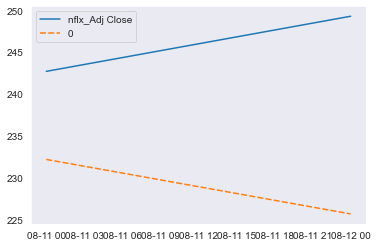

In [ ]:
sns.lineplot(data=pred_df)